## Theory Questions:

Q1: Why is the KL Divergence term important in the VAE loss function?

Ans: The KL Divergence (KLD) term is crucial because it regularizes the latent space, ensuring that the learned distribution remains close to a standard Gaussian distribution. Without this term, the latent space could become highly irregular, making it difficult to generate meaningful data from random samples. KLD ensures that the latent representations are continuous and structured, which is essential for generating realistic variations of the input data. Essentially, it helps the model learn a smooth and meaningful latent space instead of just memorizing the training data.

_______________________________________________________________________________________________________________________________________________________________________________________

Q2: How does the reparameterization trick enable backpropagation through the stochastic layers of a VAE?

Ans: The reparameterization trick is essential for training VAEs because it allows gradients to pass through the random sampling process, which is normally non-differentiable. In a standard VAE, the encoder produces two outputs: a mean and a variance, which define a probability distribution. Instead of directly sampling from this distribution, the reparameterization trick restructures the process in a way that allows backpropagation.

Instead of treating the sampled latent variable as purely random, we express it as a function of a deterministic component (mean) and a stochastic noise term. This reformulation ensures that the randomness is introduced in a way that does not disrupt gradient computation. The encoder still learns the mean and variance, but the actual sampling happens in a separate step that does not block gradients.

By doing this, the network can be trained using standard backpropagation and gradient descent, allowing it to learn meaningful latent representations. Without this trick, the gradients would not be able to flow through the stochastic layer, making it impossible to optimize the model effectively.


$$
z = \mu + \sigma \cdot \epsilon, \quad \text{where } \epsilon \sim \mathcal{N}(0,1)
$$

A deterministic part: mean (μ)
A stochastic part: random noise (𝜖) scaled by standard deviation (σ)

_______________________________________________________________________________________________________________________________________________________________________________________

Q3: Why does a VAE use a probabilistic latent space instead of a fixed latent space?

Ans: A probabilistic latent space gives VAEs the ability to generate diverse and smooth variations of input data, rather than rigidly encoding each input to a single point. Unlike traditional autoencoders, which learn deterministic embeddings, VAEs learn distributions (mean and variance) that allow sampling. This ensures that similar inputs are mapped to close-by distributions, allowing smooth transitions between different data points in the latent space. The probabilistic nature also helps with generalization, preventing overfitting and making VAEs capable of generating novel but coherent outputs.

_______________________________________________________________________________________________________________________________________________________________________________________

Q4: What role does KL Divergence play in ensuring a smooth latent space?

Ans: KL Divergence forces the latent variable distributions to be close to a standard Gaussian distribution. This smooths out the latent space by preventing it from having gaps, discontinuities, or regions with no meaningful representation. If the latent space were irregular, sampling from random points could produce unrealistic or meaningless outputs. The KLD term encourages each encoded sample to stay close to a structured, continuous distribution, ensuring that every point in the latent space corresponds to a meaningful and coherent output.

_______________________________________________________________________________________________________________________________________________________________________________________

## Coding Tasks

### Task 1

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Ensure reproducibility
torch.manual_seed(42)

# 1) Define CIFAR-10 dataset transformations
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1,1]
])

# 2) Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True, 
    transform=transform, 
    download=True
)
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=128, 
    shuffle=True
)

# 3) Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Files already downloaded and verified
Using device: cuda


In [2]:
class FCVAE(nn.Module):
    def __init__(self, input_dim=3*32*32, hidden_dim=1024, latent_dim=256):
        super(FCVAE, self).__init__()

        # -------------------
        # ENCODER
        # -------------------
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)

        # -------------------
        # DECODER
        # -------------------
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)  # Output same shape as input

    def encode(self, x):
        x = x.view(x.size(0), -1)  # Flatten image
        h = torch.relu(self.fc1(x))
        return self.fc2_mu(h), self.fc2_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.fc3(z))
        x_recon = torch.tanh(self.fc4(h))  # Tanh -> [-1,1]
        return x_recon.view(-1, 3, 32, 32)  # Reshape back to (B,3,32,32)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [3]:
class CNNVAE(nn.Module):
    def __init__(self, latent_dim=64):
        super(CNNVAE, self).__init__()
        
        # -------------------
        # ENCODER
        # -------------------
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),   # 3x32x32 -> 64x16x16
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # 64x16x16 -> 128x8x8
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),# 128x8x8 -> 256x4x4
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),# 256x4x4 -> 512x2x2
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        # After the encoder: (512,2,2) = 512*2*2 = 2048 features
        self.fc_mu = nn.Linear(512 * 2 * 2, latent_dim)
        self.fc_logvar = nn.Linear(512 * 2 * 2, latent_dim)
        
        # -------------------
        # DECODER
        # -------------------
        self.fc_z = nn.Linear(latent_dim, 512 * 2 * 2)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1), # 512x2x2 -> 256x4x4
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), # 256x4x4 -> 128x8x8
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 128x8x8 -> 64x16x16
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),    # 64x16x16 -> 3x32x32
            nn.Tanh() # final in [-1,1]
        )

    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)  # Flatten
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = self.fc_z(z)
        h = h.view(-1, 512, 2, 2)
        return self.decoder(h)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [4]:
def loss_function_l1(recon_x, x, mu, logvar, beta=0.1):
    """L1 + KL Divergence (from your original code)"""
    L1 = nn.functional.l1_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return L1 + beta * KLD, L1, KLD

def loss_function_mse(recon_x, x, mu, logvar, beta=1.0):
    """MSE + KL Divergence"""
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + beta * KLD, MSE, KLD


In [5]:
def train_vae(model, loader, optimizer, device, epochs=10, loss_fn=loss_function_l1, model_name="VAE"):
    """Train a given VAE model."""
    model.train()
    
    for epoch in range(1, epochs + 1):
        total_loss = 0
        total_recon = 0
        total_kld = 0
        
        for batch_idx, (images, _) in enumerate(loader):
            images = images.to(device)
            recon, mu, logvar = model(images)
            
            # Call whichever loss function you prefer
            loss, recon_term, kld_term = loss_fn(recon, images, mu, logvar)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            total_recon += recon_term.item()
            total_kld += kld_term.item()
            
            # Debug print for the first batch of each epoch
            if batch_idx == 0:
                print(f"Debug [{model_name}] Epoch {epoch}, Batch {batch_idx}:")
                print(f"  Recon shape: {recon.shape}, Images shape: {images.shape}")
                print(f"  Recon min: {recon.min().item():.3f}, max: {recon.max().item():.3f}")
                print(f"  Images min: {images.min().item():.3f}, max: {images.max().item():.3f}")
        
        # Average over entire dataset
        avg_loss = total_loss / len(loader.dataset)
        avg_recon = total_recon / len(loader.dataset)
        avg_kld = total_kld / len(loader.dataset)
        
        print(f"Epoch [{epoch}/{epochs}] - {model_name} Loss: {avg_loss:.4f} | Recon: {avg_recon:.4f} | KL: {avg_kld:.4f}")


Training FC-VAE...
Debug [FC-VAE] Epoch 1, Batch 0:
  Recon shape: torch.Size([128, 3, 32, 32]), Images shape: torch.Size([128, 3, 32, 32])
  Recon min: -0.822, max: 0.783
  Images min: -1.000, max: 1.000
Epoch [1/20] - FC-VAE Loss: 567.3007 | Recon: 538.9085 | KL: 283.9219
Debug [FC-VAE] Epoch 2, Batch 0:
  Recon shape: torch.Size([128, 3, 32, 32]), Images shape: torch.Size([128, 3, 32, 32])
  Recon min: -0.987, max: 0.976
  Images min: -1.000, max: 1.000
Epoch [2/20] - FC-VAE Loss: 450.3942 | Recon: 418.8267 | KL: 315.6752
Debug [FC-VAE] Epoch 3, Batch 0:
  Recon shape: torch.Size([128, 3, 32, 32]), Images shape: torch.Size([128, 3, 32, 32])
  Recon min: -0.973, max: 0.982
  Images min: -1.000, max: 1.000
Epoch [3/20] - FC-VAE Loss: 424.7055 | Recon: 393.0725 | KL: 316.3299
Debug [FC-VAE] Epoch 4, Batch 0:
  Recon shape: torch.Size([128, 3, 32, 32]), Images shape: torch.Size([128, 3, 32, 32])
  Recon min: -0.976, max: 0.990
  Images min: -1.000, max: 1.000
Epoch [4/20] - FC-VAE Loss:

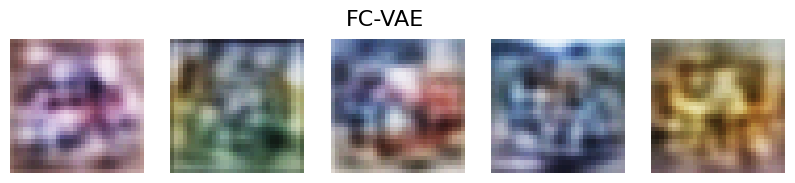

In [6]:
# FC-VAE 
fc_vae = FCVAE(input_dim=3*32*32, hidden_dim=1024, latent_dim=128).to(device)
optimizer_fc = optim.Adam(fc_vae.parameters(), lr=1e-3)

print("Training FC-VAE...")
# By default, use your original L1+KL loss with beta=0.1
train_vae(fc_vae, train_loader, optimizer_fc, device, epochs=20, loss_fn=loss_function_l1, model_name="FC-VAE")

def generate_images(model, latent_dim=128, num_images=5, title="Generated Images"):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_images, latent_dim).to(device)
        generated = model.decode(z).cpu()

    fig, axs = plt.subplots(1, num_images, figsize=(num_images*2, 2))
    fig.suptitle(title, fontsize=16)
    for i in range(num_images):
        # Convert [-1,1] -> [0,1] for viewing
        img = generated[i].permute(1, 2, 0).numpy()
        img = (img + 1.0) / 2.0
        axs[i].imshow(img)
        axs[i].axis('off')
    plt.show()

print("\nGenerated images from FC-VAE:")
generate_images(fc_vae, latent_dim=128, num_images=5, title="FC-VAE")



Training  CNN-VAE...
Debug [CNNVAE] Epoch 1, Batch 0:
  Recon shape: torch.Size([128, 3, 32, 32]), Images shape: torch.Size([128, 3, 32, 32])
  Recon min: -1.000, max: 1.000
  Images min: -1.000, max: 1.000
Epoch [1/20] - CNNVAE Loss: 3753.5697 | Recon: 333.9712 | KL: 3419.5987
Debug [CNNVAE] Epoch 2, Batch 0:
  Recon shape: torch.Size([128, 3, 32, 32]), Images shape: torch.Size([128, 3, 32, 32])
  Recon min: -0.940, max: 0.965
  Images min: -1.000, max: 1.000
Epoch [2/20] - CNNVAE Loss: 267.4434 | Recon: 224.0075 | KL: 43.4359
Debug [CNNVAE] Epoch 3, Batch 0:
  Recon shape: torch.Size([128, 3, 32, 32]), Images shape: torch.Size([128, 3, 32, 32])
  Recon min: -0.976, max: 0.989
  Images min: -1.000, max: 1.000
Epoch [3/20] - CNNVAE Loss: 245.8832 | Recon: 200.7094 | KL: 45.1738
Debug [CNNVAE] Epoch 4, Batch 0:
  Recon shape: torch.Size([128, 3, 32, 32]), Images shape: torch.Size([128, 3, 32, 32])
  Recon min: -0.962, max: 0.981
  Images min: -1.000, max: 1.000
Epoch [4/20] - CNNVAE Lo

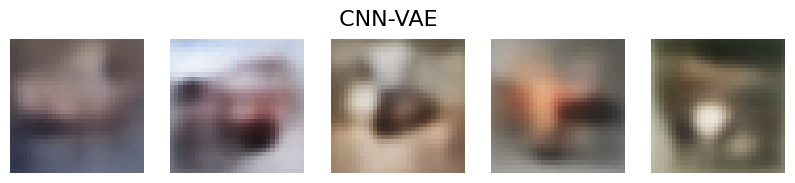

In [7]:
# CNN-VAE
cnn_vae = CNNVAE(latent_dim=64).to(device)
optimizer_cnn = optim.Adam(cnn_vae.parameters(), lr=1e-3)

print("\nTraining  CNN-VAE...")
# We'll use MSE+KL with beta=1.0
train_vae(cnn_vae, train_loader, optimizer_cnn, device, epochs=20, loss_fn=loss_function_mse, model_name="CNNVAE")

def generate_images_cnn(model, latent_dim=64, num_images=5, title="Generated Images"):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_images, latent_dim).to(device)
        generated = model.decode(z).cpu()

    fig, axs = plt.subplots(1, num_images, figsize=(num_images*2, 2))
    fig.suptitle(title, fontsize=16)
    for i in range(num_images):
        # Convert [-1,1] -> [0,1] for viewing09
        img = generated[i].permute(1, 2, 0).numpy()
        img = (img + 1.0) / 2.0
        axs[i].imshow(img)
        axs[i].axis('off')
    plt.show()

print("\nGenerated images from  CNN-VAE:")
generate_images_cnn(cnn_vae, latent_dim=64, num_images=5, title=" CNN-VAE")


### Task 2 - Interpolation

In [8]:
import numpy as np

def interpolate_images(model, dataloader, latent_dim=128, num_steps=8, title="Latent Space Interpolation"):
    """
    Interpolates between two randomly chosen images from the dataset using a trained VAE model.
    
    Parameters:
    - model: The trained VAE model (FC-VAE or CNN-VAE).
    - dataloader: DataLoader for dataset.
    - latent_dim: Dimension of the latent space.
    - num_steps: Number of intermediate steps between the two images.
    - title: Title of the plot.
    """
    model.eval()
    
    # Select two random images from the dataset
    data_iter = iter(dataloader)
    img1, _ = next(data_iter)  # First image
    img2, _ = next(data_iter)  # Second image

    img1, img2 = img1[0].unsqueeze(0).to(device), img2[0].unsqueeze(0).to(device)  # Select batch 1

    # Encode both images to latent space
    with torch.no_grad():
        mu1, logvar1 = model.encode(img1)
        mu2, logvar2 = model.encode(img2)

        z1 = model.reparameterize(mu1, logvar1)
        z2 = model.reparameterize(mu2, logvar2)

    # Generate intermediate latent vectors
    alphas = np.linspace(0, 1, num_steps)  # Interpolation weights
    interpolated_zs = [z1 * (1 - alpha) + z2 * alpha for alpha in alphas]

    # Decode the latent vectors back into images
    with torch.no_grad():
        interpolated_images = [model.decode(z).cpu() for z in interpolated_zs]

    # Plot the images
    fig, axs = plt.subplots(1, num_steps + 2, figsize=(num_steps * 2, 2))
    fig.suptitle(title, fontsize=16)

    # Show original images at the start and end
    axs[0].imshow(img1.cpu().squeeze().permute(1, 2, 0).numpy() * 0.5 + 0.5)  # Convert [-1,1] to [0,1]
    axs[0].axis("off")
    axs[0].set_title("Start Image")

    axs[-1].imshow(img2.cpu().squeeze().permute(1, 2, 0).numpy() * 0.5 + 0.5)  # Convert [-1,1] to [0,1]
    axs[-1].axis("off")
    axs[-1].set_title("End Image")

    # Show interpolated images
    for i, img in enumerate(interpolated_images):
        img = img.squeeze().permute(1, 2, 0).numpy()
        img = (img + 1.0) / 2.0  # Convert from [-1,1] to [0,1]
        axs[i + 1].imshow(img)
        axs[i + 1].axis("off")

    plt.show()



Interpolating Images using FC-VAE...


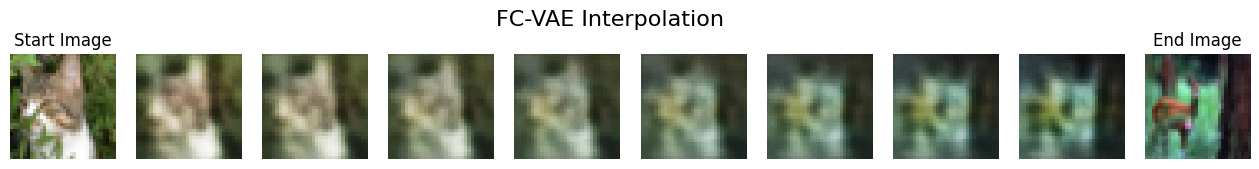

In [9]:
print("\nInterpolating Images using FC-VAE...")
interpolate_images(fc_vae, train_loader, latent_dim=128, num_steps=8, title="FC-VAE Interpolation")



Interpolating Images using CNN-VAE...


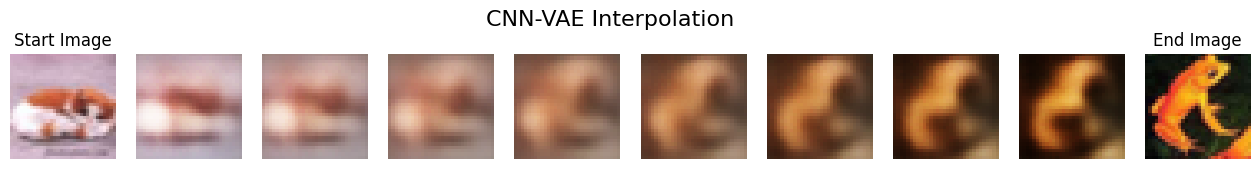

In [10]:
print("\nInterpolating Images using CNN-VAE...")
interpolate_images(cnn_vae, train_loader, latent_dim=64, num_steps=8, title="CNN-VAE Interpolation")


### Task 3 - New Dataset


Please use this link to download the dataset: https://www.kaggle.com/datasets/gpiosenka/butterfly-images40-species

Once downloaded, use the 'train' folder for the below code. 

In [11]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Define Transformations
transform_butterfly = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize images to match VAE input
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1,1]
])

# Load dataset using ImageFolder
dataset_path = r"C:\Users\sanje\Documents\WPI_Sem_4_Docs\GenAI\Assignment 3\train"  
train_dataset_butterfly = ImageFolder(root=dataset_path, transform=transform_butterfly)

# Create DataLoader
train_loader_butterfly = DataLoader(train_dataset_butterfly, batch_size=128, shuffle=True)

print(f"Loaded Butterfly & Moth dataset with {len(train_dataset_butterfly)} images!")


cuda
Loaded Butterfly & Moth dataset with 12594 images!


In [12]:
# Instantiate FC-VAE
fc_vae_butterfly = FCVAE().to(device)
optimizer_fc_butterfly = torch.optim.Adam(fc_vae_butterfly.parameters(), lr=1e-3)

print("\n Training FC-VAE on Butterfly Dataset...")
train_vae(fc_vae_butterfly, train_loader_butterfly, optimizer_fc_butterfly, device, epochs=10, 
          loss_fn=loss_function_l1, model_name="FC-VAE Butterfly")



 Training FC-VAE on Butterfly Dataset...
Debug [FC-VAE Butterfly] Epoch 1, Batch 0:
  Recon shape: torch.Size([128, 3, 32, 32]), Images shape: torch.Size([128, 3, 32, 32])
  Recon min: -0.811, max: 0.815
  Images min: -1.000, max: 1.000
Epoch [1/10] - FC-VAE Butterfly Loss: 797.5738 | Recon: 768.1634 | KL: 294.1043
Debug [FC-VAE Butterfly] Epoch 2, Batch 0:
  Recon shape: torch.Size([128, 3, 32, 32]), Images shape: torch.Size([128, 3, 32, 32])
  Recon min: -0.993, max: 0.996
  Images min: -1.000, max: 1.000
Epoch [2/10] - FC-VAE Butterfly Loss: 627.4493 | Recon: 593.6682 | KL: 337.8110
Debug [FC-VAE Butterfly] Epoch 3, Batch 0:
  Recon shape: torch.Size([128, 3, 32, 32]), Images shape: torch.Size([128, 3, 32, 32])
  Recon min: -0.987, max: 0.997
  Images min: -1.000, max: 1.000
Epoch [3/10] - FC-VAE Butterfly Loss: 577.7884 | Recon: 540.9389 | KL: 368.4950
Debug [FC-VAE Butterfly] Epoch 4, Batch 0:
  Recon shape: torch.Size([128, 3, 32, 32]), Images shape: torch.Size([128, 3, 32, 32])

In [13]:
# Instantiate CNN-VAE
cnn_vae_butterfly = CNNVAE().to(device)
optimizer_cnn_butterfly = torch.optim.Adam(cnn_vae_butterfly.parameters(), lr=1e-3)

print("\n Training CNN-VAE on Butterfly Dataset...")
train_vae(cnn_vae_butterfly, train_loader_butterfly, optimizer_cnn_butterfly, device, epochs=10, 
          loss_fn=loss_function_mse, model_name="CNN-VAE Butterfly")



 Training CNN-VAE on Butterfly Dataset...
Debug [CNN-VAE Butterfly] Epoch 1, Batch 0:
  Recon shape: torch.Size([128, 3, 32, 32]), Images shape: torch.Size([128, 3, 32, 32])
  Recon min: -1.000, max: 1.000
  Images min: -1.000, max: 1.000
Epoch [1/10] - CNN-VAE Butterfly Loss: 493836621.6463 | Recon: 503.1431 | KL: 493836126.6051
Debug [CNN-VAE Butterfly] Epoch 2, Batch 0:
  Recon shape: torch.Size([128, 3, 32, 32]), Images shape: torch.Size([128, 3, 32, 32])
  Recon min: -0.923, max: 0.984
  Images min: -1.000, max: 1.000
Epoch [2/10] - CNN-VAE Butterfly Loss: 381.5888 | Recon: 348.7887 | KL: 32.8001
Debug [CNN-VAE Butterfly] Epoch 3, Batch 0:
  Recon shape: torch.Size([128, 3, 32, 32]), Images shape: torch.Size([128, 3, 32, 32])
  Recon min: -0.954, max: 0.986
  Images min: -1.000, max: 1.000
Epoch [3/10] - CNN-VAE Butterfly Loss: 348.6635 | Recon: 316.6952 | KL: 31.9683
Debug [CNN-VAE Butterfly] Epoch 4, Batch 0:
  Recon shape: torch.Size([128, 3, 32, 32]), Images shape: torch.Size


Generated images from FC-VAE trained on Butterflies:


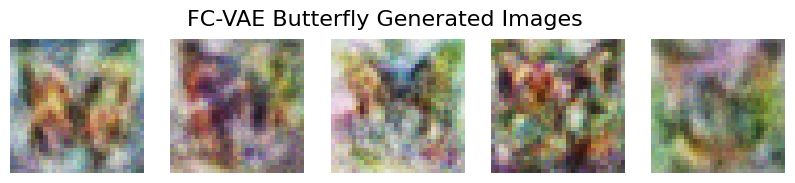


 Generated images from CNN-VAE trained on Butterflies:


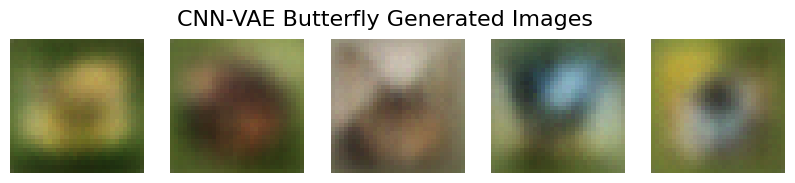

In [15]:
print("\nGenerated images from FC-VAE trained on Butterflies:")
generate_images(fc_vae_butterfly, latent_dim=256, num_images=5, title="FC-VAE Butterfly Generated Images")

print("\n Generated images from CNN-VAE trained on Butterflies:")
generate_images_cnn(cnn_vae_butterfly, latent_dim=64, num_images=5, title="CNN-VAE Butterfly Generated Images")



Interpolating FC-VAE Latent Space on Butterfly Dataset:


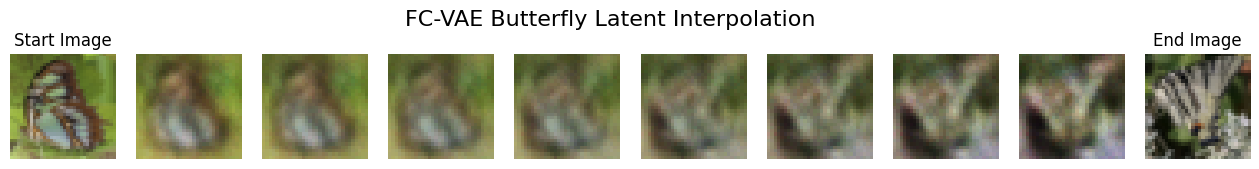


Interpolating CNN-VAE Latent Space on Butterfly Dataset:


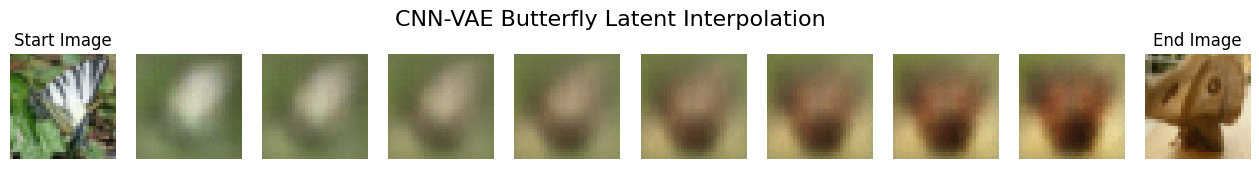

In [16]:
print("\nInterpolating FC-VAE Latent Space on Butterfly Dataset:")
interpolate_images(fc_vae_butterfly, train_loader_butterfly, latent_dim=256, num_steps=8, title="FC-VAE Butterfly Latent Interpolation")

print("\nInterpolating CNN-VAE Latent Space on Butterfly Dataset:")
interpolate_images(cnn_vae_butterfly, train_loader_butterfly, latent_dim=64, num_steps=8, title="CNN-VAE Butterfly Latent Interpolation")


Submitted By: Sanjeeth Nagappa Chakrasali